## Individual cell-based differential transcriptomic analysis across conditions

In [1]:
path = '/home/mid166/Analysis/Jupyter/Python/Package/PIASO_github'
import sys
sys.path.append(path)
import piaso ## Available in https://github.com/genecell/PIASO

/n/data1/hms/neurobio/fishell/mindai/.conda/envs/scda5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scanpy as sc

In [3]:
import pandas as pd
import numpy as np

In [4]:
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')
from matplotlib import rcParams
rcParams['figure.figsize'] = 4, 4
save_dir='/n/data1/hms/neurobio/fishell/mindai/Result/single-cell/Methods/Emergene'
sc.settings.figdir = save_dir
prefix='Emergene_Tutorial'

### Load the data

The 25k subsampled snRNA-seq data `SEA-AD_CaseControl_subset_log1p_25k.h5ad` from Allen SEA-AD project is available in google drive: https://drive.google.com/file/d/1YLdzJPFuKFrSYTc82bLMKmFGSZwsTAck.

The original data is available in https://portal.brain-map.org/explore/seattle-alzheimers-disease.

You can use gdrive to download the above dataset to your space:
```
mkdir -p /n/data1/hms/neurobio/fishell/mindai/Result/single-cell/Methods/Emergene/
cd /n/data1/hms/neurobio/fishell/mindai/Result/single-cell/Methods/Emergene/
gdrive files download 1YLdzJPFuKFrSYTc82bLMKmFGSZwsTAck
```

In [5]:
adata=sc.read('/n/data1/hms/neurobio/fishell/mindai/Result/single-cell/Methods/Emergene/SEA-AD_CaseControl_subset_log1p_25k.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 25600 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mont

In [7]:
pd.crosstab(adata.obs['Neurotypical reference'], adata.obs['CERAD score'])

CERAD score             Absent  Frequent
Neurotypical reference                  
False                    10264     15336

### Check the cell type composition

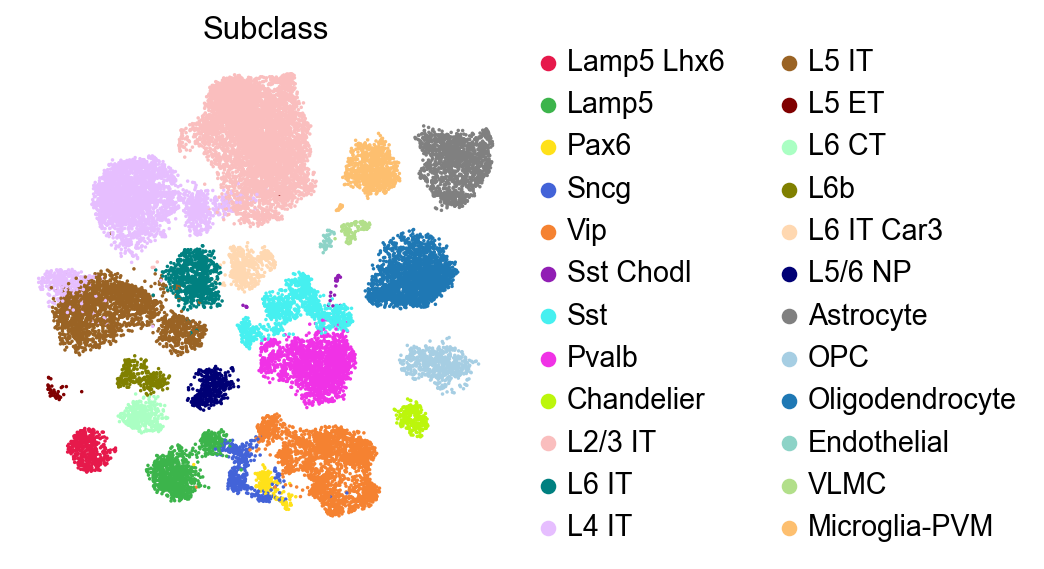

In [8]:
sc.pl.embedding(adata,
            basis='X_umap',
           color=['Subclass'],
           palette=piaso.pl.color.d_color3,
           legend_fontoutline=2,
           legend_fontweight=5,
           cmap='Spectral_r',
           ncols=3,
           size=10,
           frameon=False)

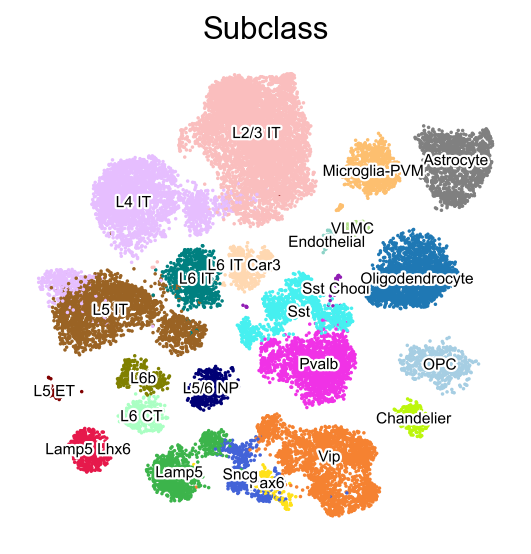

In [9]:
sc.pl.embedding(adata,
    basis='X_umap',
    color=['Subclass'],
    palette=piaso.pl.color.d_color3,
    legend_fontoutline=2,
    legend_fontsize=7,
    legend_fontweight=5,
    legend_loc='on data',
    cmap='Spectral_r',
    ncols=3,
    size=10,
    frameon=False)

### Run Emergene

In [10]:
path = '/home/mid166/Analysis/Jupyter/Python/Package/Emergene_github' ### Available in https://github.com/genecell/Emergene
import sys
sys.path.append(path)
import emergene as eg

In [11]:
%%time
piaso.tl.infog(adata, layer='UMIs')

The normalized data is saved as `infog` in `adata.layers`.
The highly variable genes are saved as `highly_variable` in `adata.var`.
Finished INFOG normalization.
CPU times: user 6.53 s, sys: 2.07 s, total: 8.6 s
Wall time: 8.63 s


In [12]:
sc.pp.calculate_qc_metrics(adata, layer='UMIs', inplace=True)

In [13]:
%%time
EG_top_geneset_dict, EG_score_all=eg.tl.runEMERGENE(
    adata,
    layer='infog',
    use_rep='X_scVI',
    use_rep_acrossDataset='X_scVI',
    condition_key='Condition',
    n_nearest_neighbors=10,
    n_repeats=5,
    mu=0.1,
    beta=1,
    random_seed=27,
    n_cells_expressed_threshold = 50, ### Change the number of cells threshold
    n_top_EG_genes = 500, ### Change the number of top gene with highest Emergene scores
    inplace=False,
    gene_list_as_string=True,
)

emergene v1.0.0 - runEMERGENE
Number of cells: 25600
Number of genes: 36601
Number of conditions: 2
Conditions: Control, Disease
Parameters:
  - n_neighbors: 10
  - mu: 0.1, beta: 1, sigma: 100.0
  - n_repeats: 5
  - n_top_EG_genes: 500

Building cross-dataset adjacency matrix...

Processing condition: Control
------------------------------------------------------------
  ✓ Scores added to output DataFrame

Processing condition: Disease
------------------------------------------------------------
  ✓ Scores added to output DataFrame

Finalizing results...
✓ Local fold changes saved in adata.layers['localFC']
✓ Analysis complete!

CPU times: user 3min 1s, sys: 21.7 s, total: 3min 22s
Wall time: 2min 50s


### Calculate enrichment score and p-values for each individual cell

Use 1000 permutations:

In [14]:
EG_top_geneset_dict.keys()

dict_keys(['EG_Control', 'EG_Disease'])

In [15]:
%%time
valid_genes = set(adata.var_names)
for group, gene_and_weight in EG_top_geneset_dict.items():
    # Parse and filter the dictionary in one step, only keep the genes in adata.var_names
    gene_dict = {k: float(v) for k, v in (item.split(":") for item in gene_and_weight.split(",")) if k in valid_genes}
    gene_list=list(gene_dict.keys())
    gene_weight=list(gene_dict.values())
    print(f'Processing {group}')
    
    
    piaso.tl.score(
        adata,
        gene_list=gene_list,
        gene_weights=gene_weight,
        layer='localFC',
        # layer='log1p',
        # gene_weights=np.repeat(1.0, len(gene_list)),
        n_nearest_neighbors=30,
        random_seed=27,
        n_ctrl_set=1000,
        key_added=f'INFOG_{group}',       
    )

Processing EG_Control
Processing EG_Disease
CPU times: user 34.7 s, sys: 4.77 s, total: 39.5 s
Wall time: 39.6 s


In [16]:
for key in EG_top_geneset_dict.keys():
    print(key)
    adata.obs[f'{key}_score']=adata.uns[f'INFOG_{key}']['score']
    adata.obs[f'{key}_nlog10_pval']=adata.uns[f'INFOG_{key}']['nlog10_pval']
    adata.obs[f'{key}_nlog10_FDR']=adata.uns[f'INFOG_{key}']['nlog10_pval_FDR']
    adata.obs[f'{key}_pval']=adata.uns[f'INFOG_{key}']['pval']
    adata.obs[f'{key}_FDR']=adata.uns[f'INFOG_{key}']['pval_FDR']
    adata.obs[f'{key}_pval_mc']=adata.uns[f'INFOG_{group}']['pval_mc']
    adata.obs[f'{key}_nlog10_pval_mc']=adata.uns[f'INFOG_{key}']['nlog10_pval_mc']
    adata.obs[f'{key}_nlog10_mc_FDR']=adata.uns[f'INFOG_{key}']['nlog10_pval_mc_FDR']

EG_Control
EG_Disease


In [17]:
adata.obs['SubclassXCondition'] = piaso.pp.getCrossCategories(adata.obs, 'Subclass', 'Condition', )

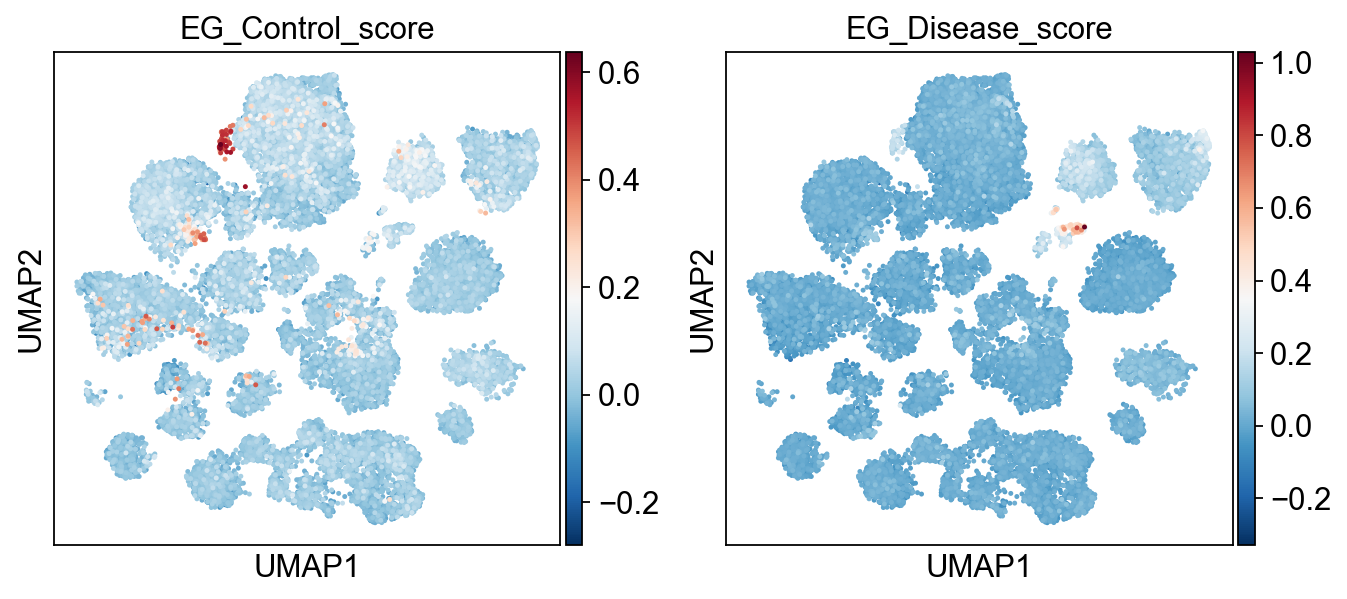

In [18]:
sc.pl.umap(
    adata,
    color=[key+'_score' for key in EG_top_geneset_dict.keys()],
    color_map="RdBu_r",
    # color_map=piaso.pl.color.c_color4,
    # vmin=-5,
    # vmax=5,
    s=20,
)

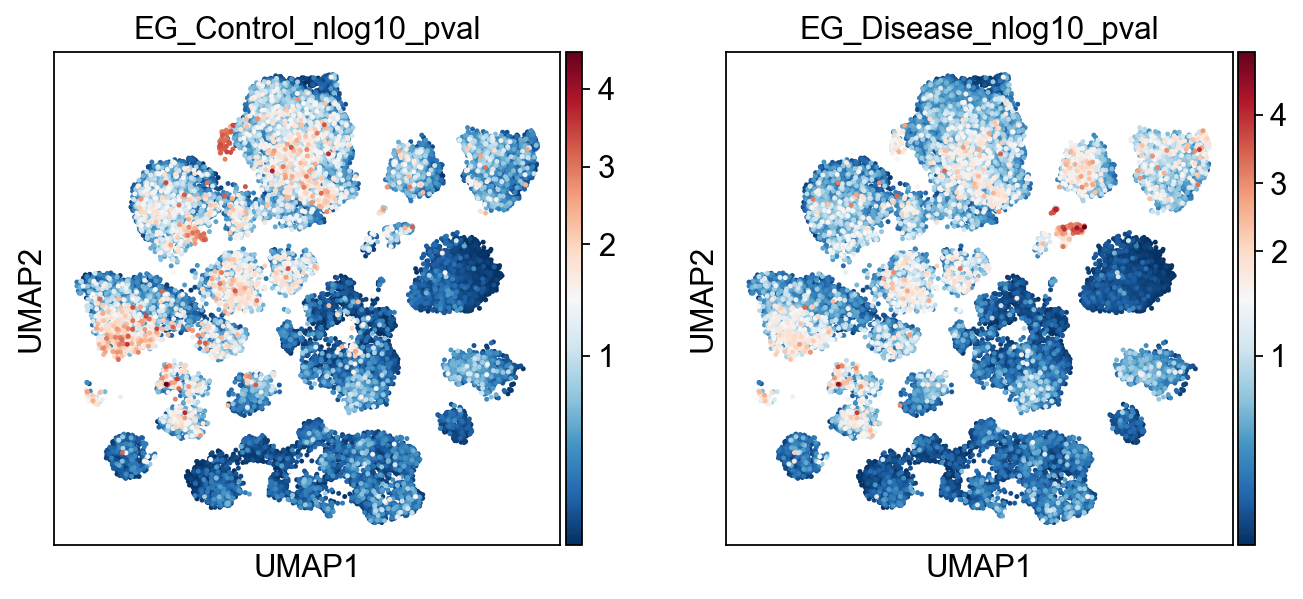

In [19]:
sc.pl.umap(
    adata,
    color=[key+'_nlog10_pval' for key in EG_top_geneset_dict.keys()],
    color_map="RdBu_r",
    # color_map=piaso.pl.color.c_color4,
    vcenter=-np.log10(0.05),
    # vmin=-5,
    # vmax=5,
    s=20,
)

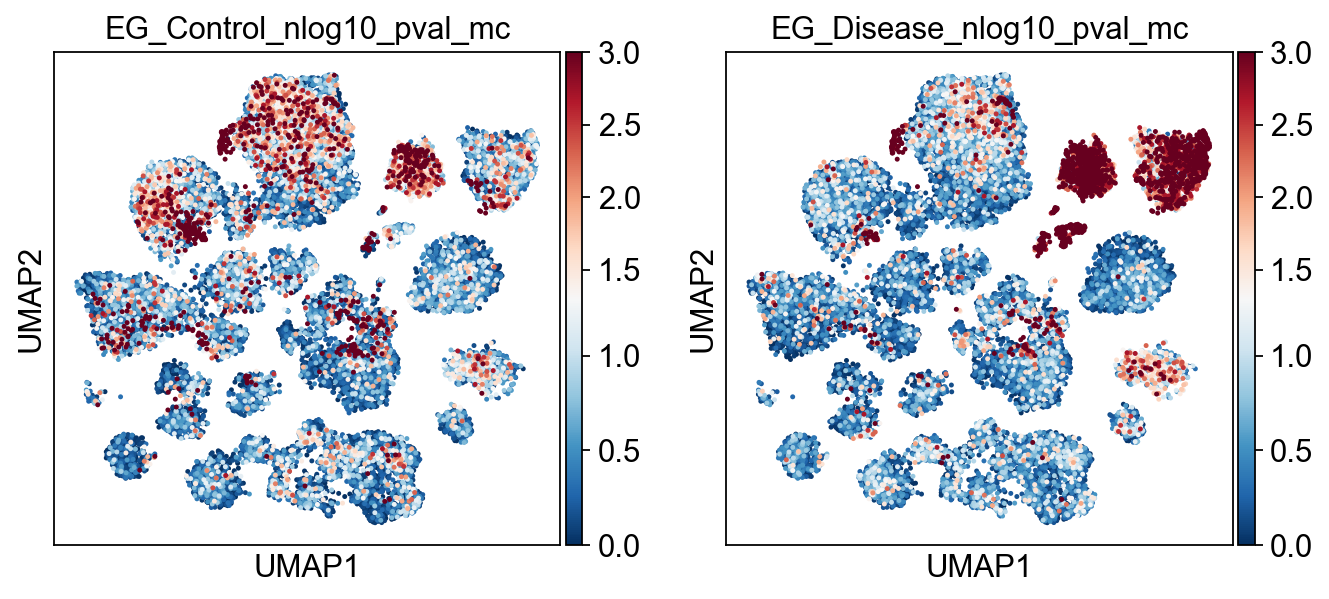

In [20]:
sc.pl.umap(
    adata,
    color=[key+'_nlog10_pval_mc' for key in EG_top_geneset_dict.keys()],
    color_map="RdBu_r",
    vcenter=-np.log10(0.05),
    s=20,
)

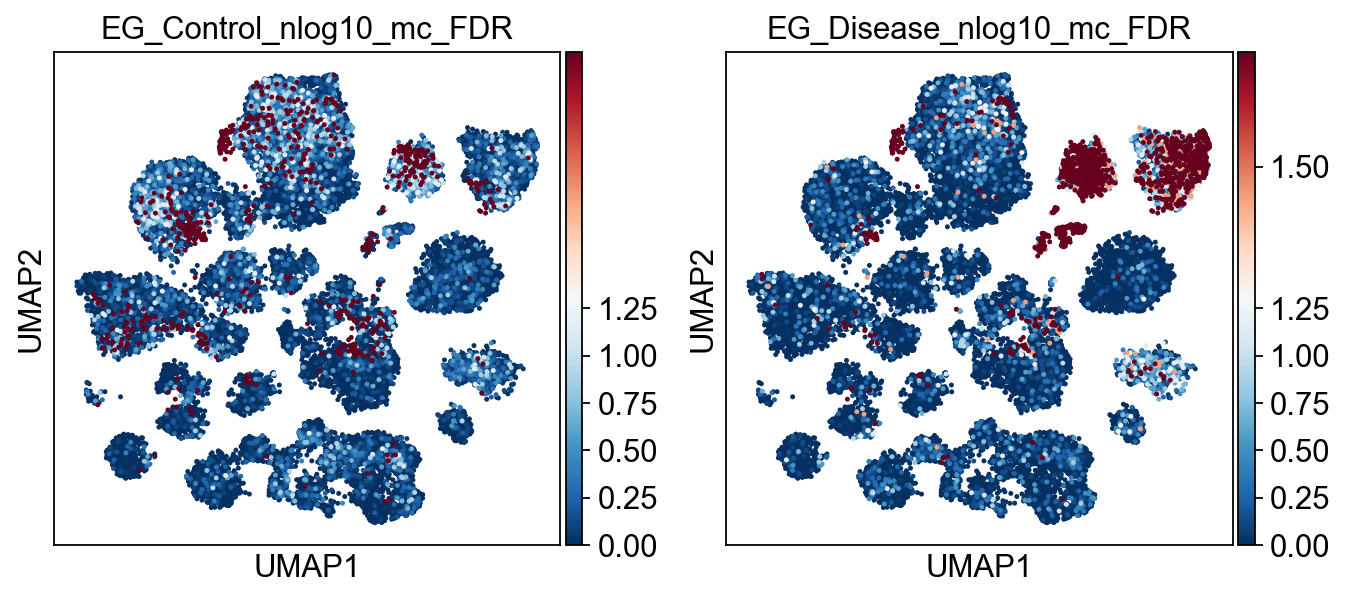

In [21]:
sc.pl.umap(
    adata,
    color=[key+'_nlog10_mc_FDR' for key in EG_top_geneset_dict.keys()],
    color_map="RdBu_r",
    vcenter=-np.log10(0.05),
    s=20,
)

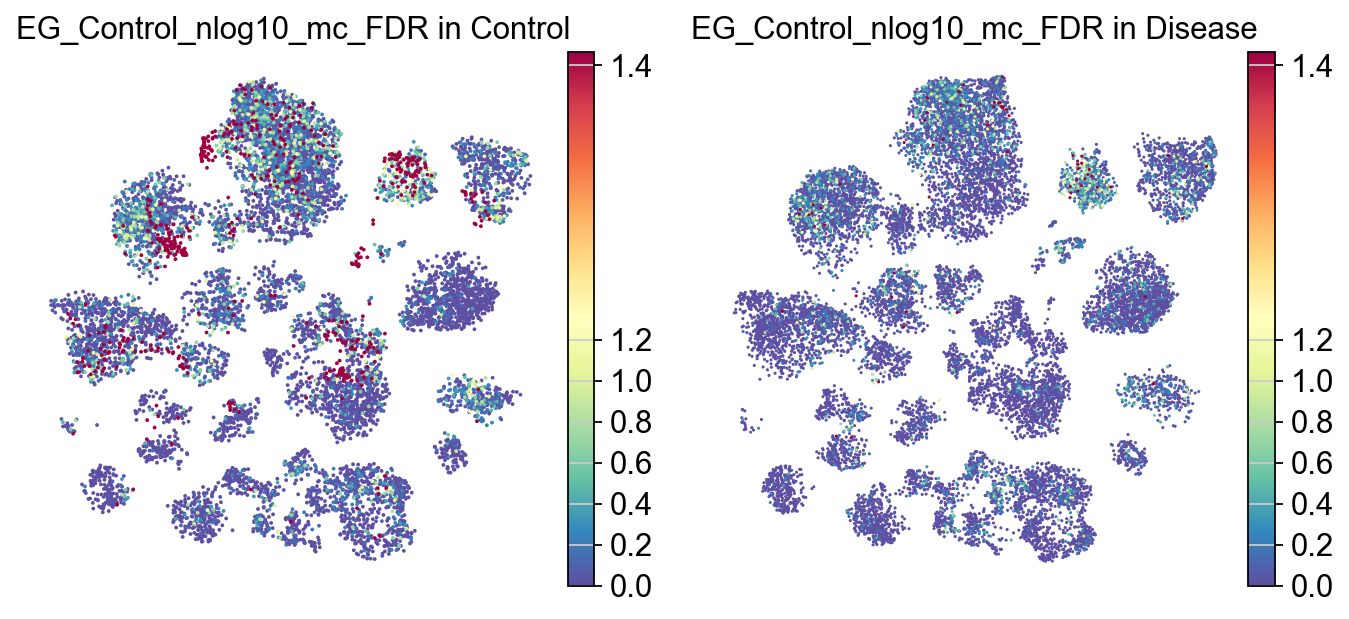

In [22]:
piaso.pl.plot_embeddings_split(
    adata,
    color='EG_Control_nlog10_mc_FDR',
    layer='log1p',
    splitby='Condition',
    color_map="Spectral_r",
    vcenter=-np.log10(0.05),
    # size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

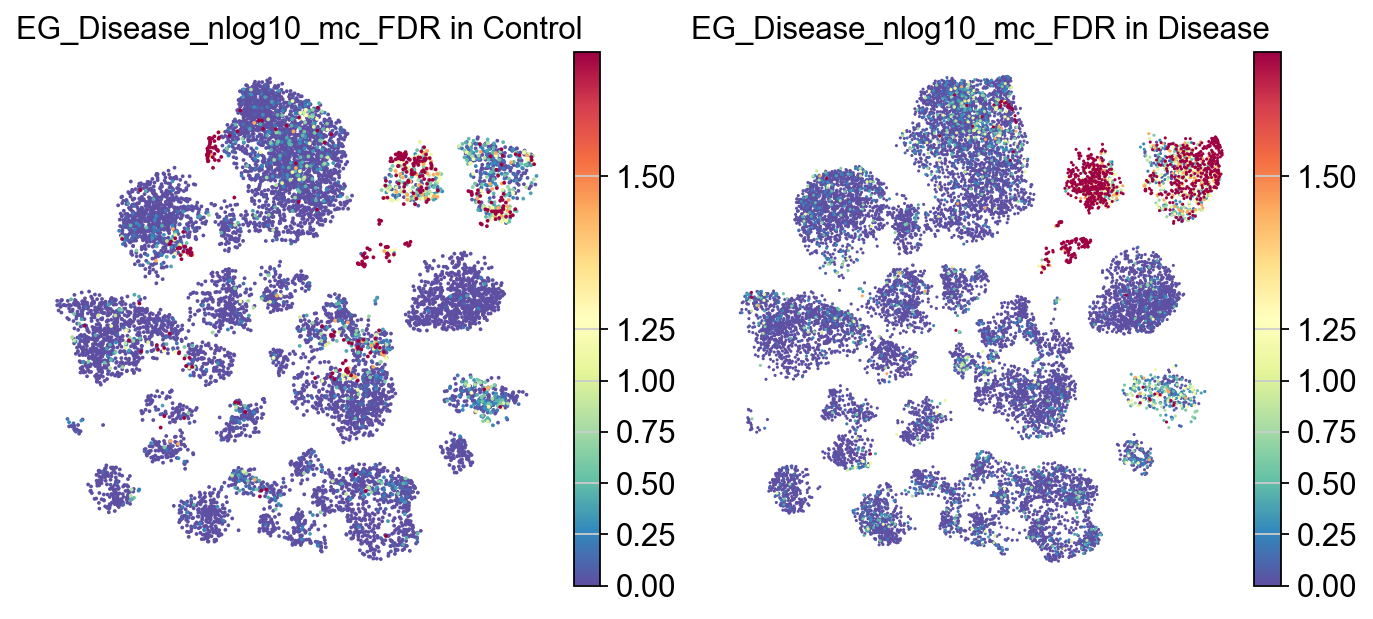

In [23]:
piaso.pl.plot_embeddings_split(
    adata,
    color='EG_Disease_nlog10_mc_FDR',
    layer='log1p',
    splitby='Condition',
    color_map="Spectral_r",
    vcenter=-np.log10(0.05),
    # size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

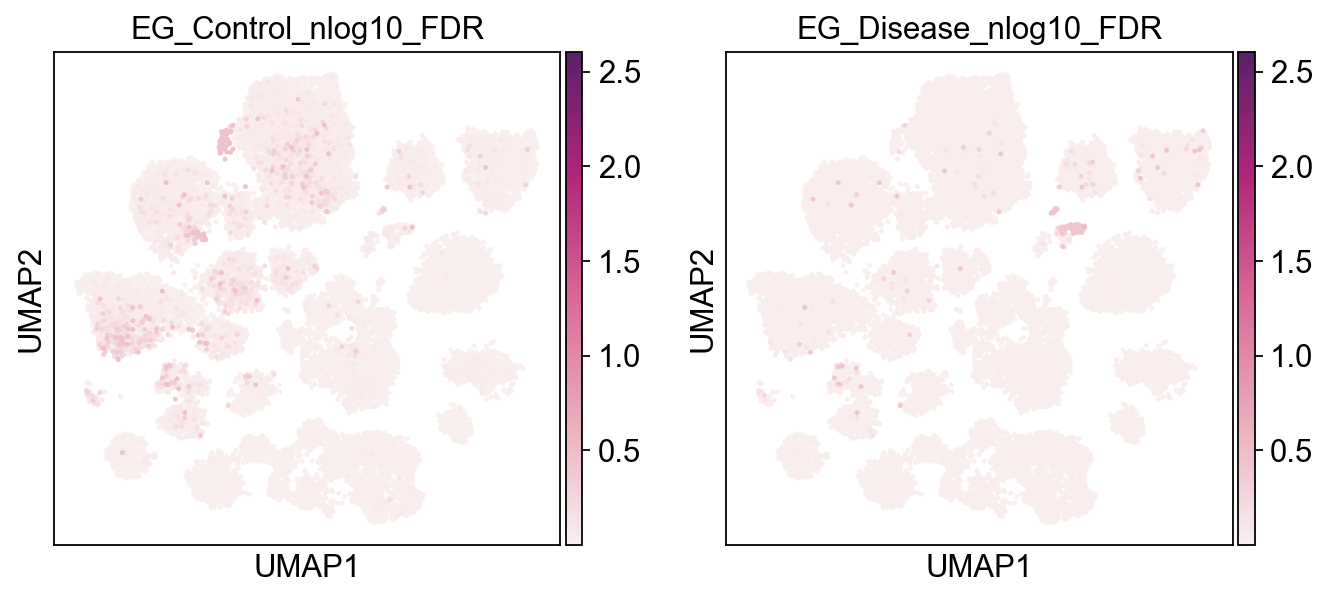

In [24]:
sc.pl.umap(
    adata,
    color=[key+'_nlog10_FDR' for key in EG_top_geneset_dict.keys()],
    # color_map="RdBu_r",
    color_map=piaso.pl.color.c_color4,
    vcenter=-np.log10(0.05),
    # vmin=-5,
    # vmax=5,
    s=20,
)

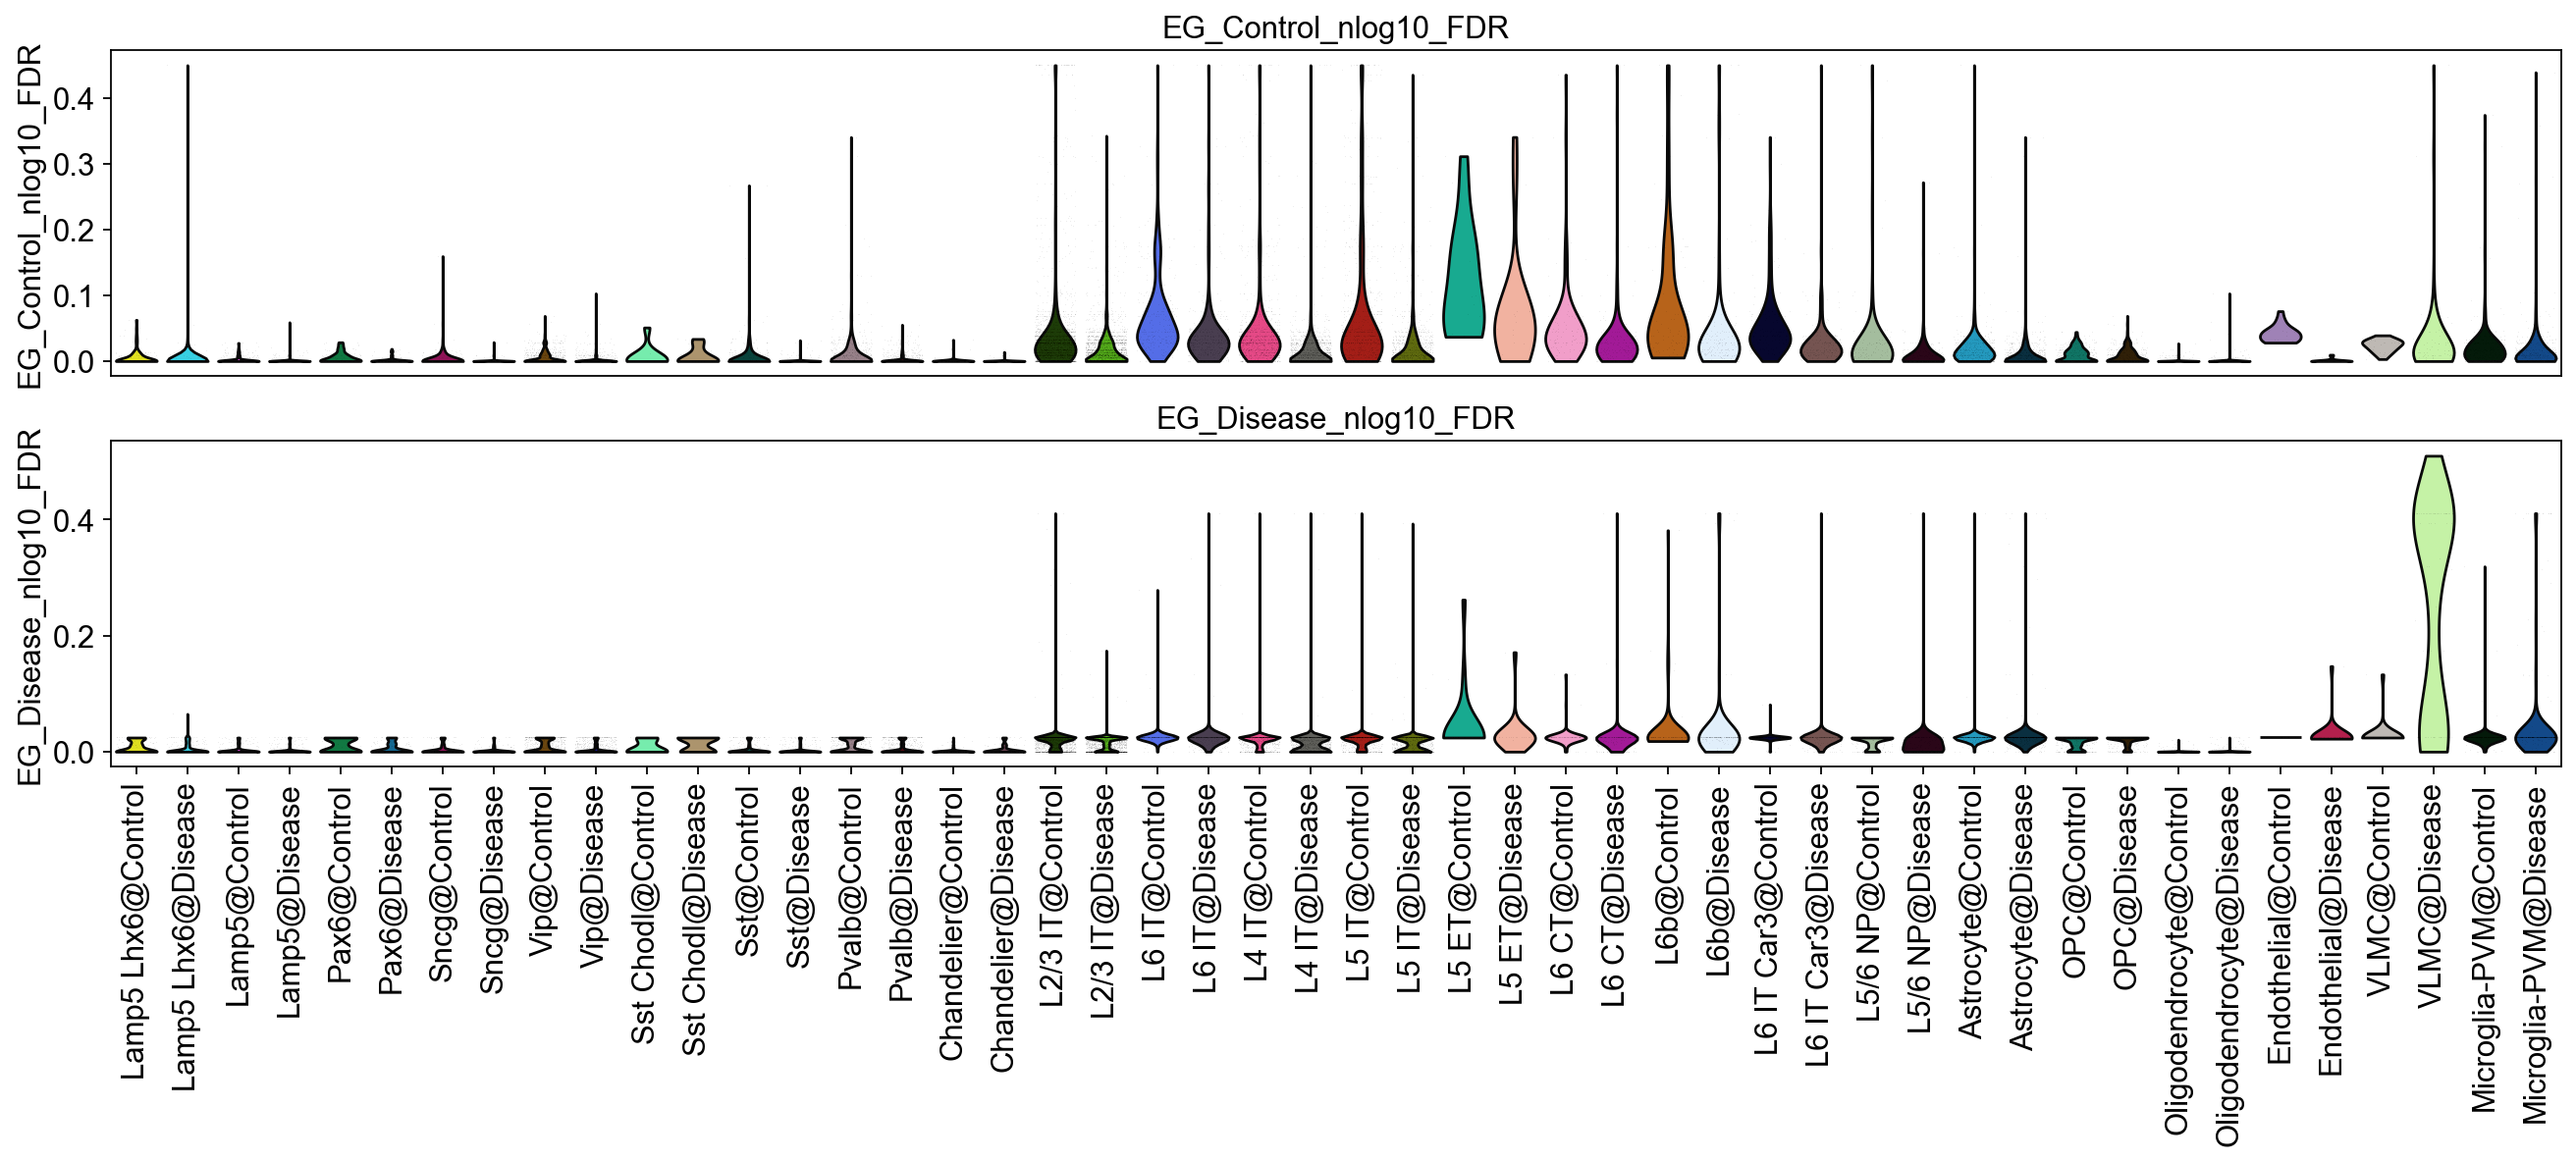

In [25]:
piaso.pl.plot_features_violin(adata,
    feature_list=[key+'_nlog10_FDR' for key in EG_top_geneset_dict.keys()],
    width_single=20,
    height_single=3,
    groupby='SubclassXCondition',
    show_grid=False
                             )

In [26]:
for key in EG_top_geneset_dict.keys():
    tmp=adata.obs[key+'_nlog10_pval_mc'].copy()
    tmp[tmp<= (-np.log10(0.05))]=0
    adata.obs[key+'_nlog10_mc_trim']=tmp

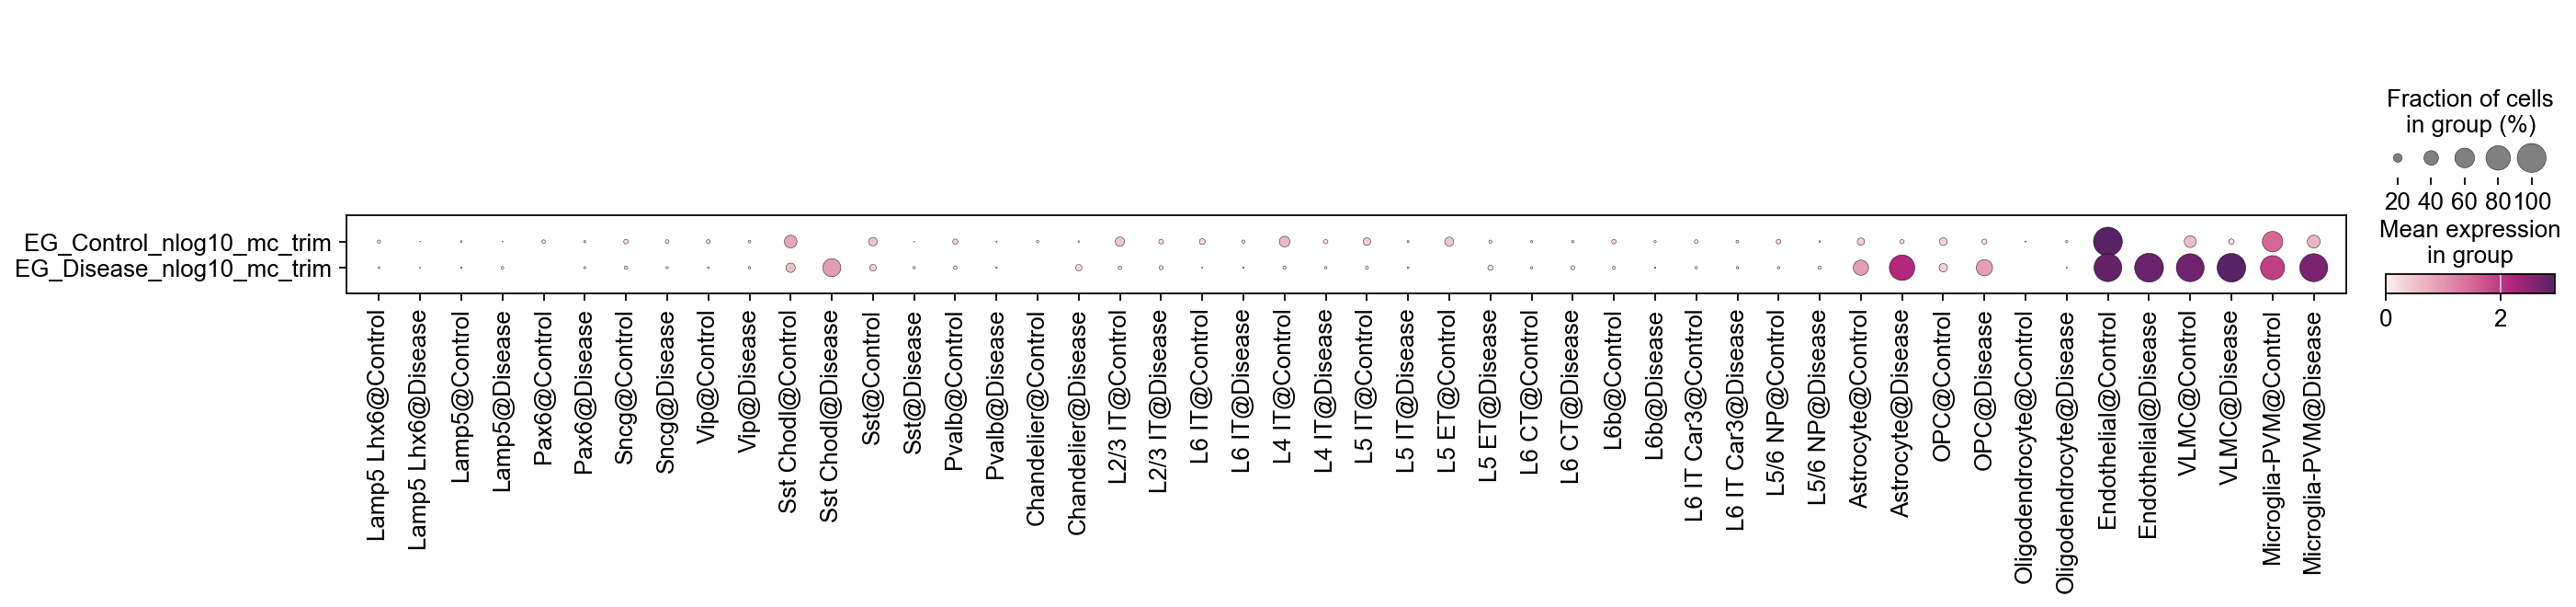

In [27]:
sc.pl.dotplot(
    adata,
    var_names=[key+'_nlog10_mc_trim' for key in EG_top_geneset_dict.keys()],
    groupby='SubclassXCondition',
    swap_axes=True,
    cmap=piaso.pl.color.c_color4
)

In [28]:
for key in EG_top_geneset_dict.keys():
    tmp=adata.obs[key+'_nlog10_mc_FDR'].copy()
    tmp[tmp<= (-np.log10(0.05))]=0
    # tmp[tmp<= (-np.log10(0.1))]=0
    adata.obs[key+'_nlog10_mc_FDR_trim']=tmp

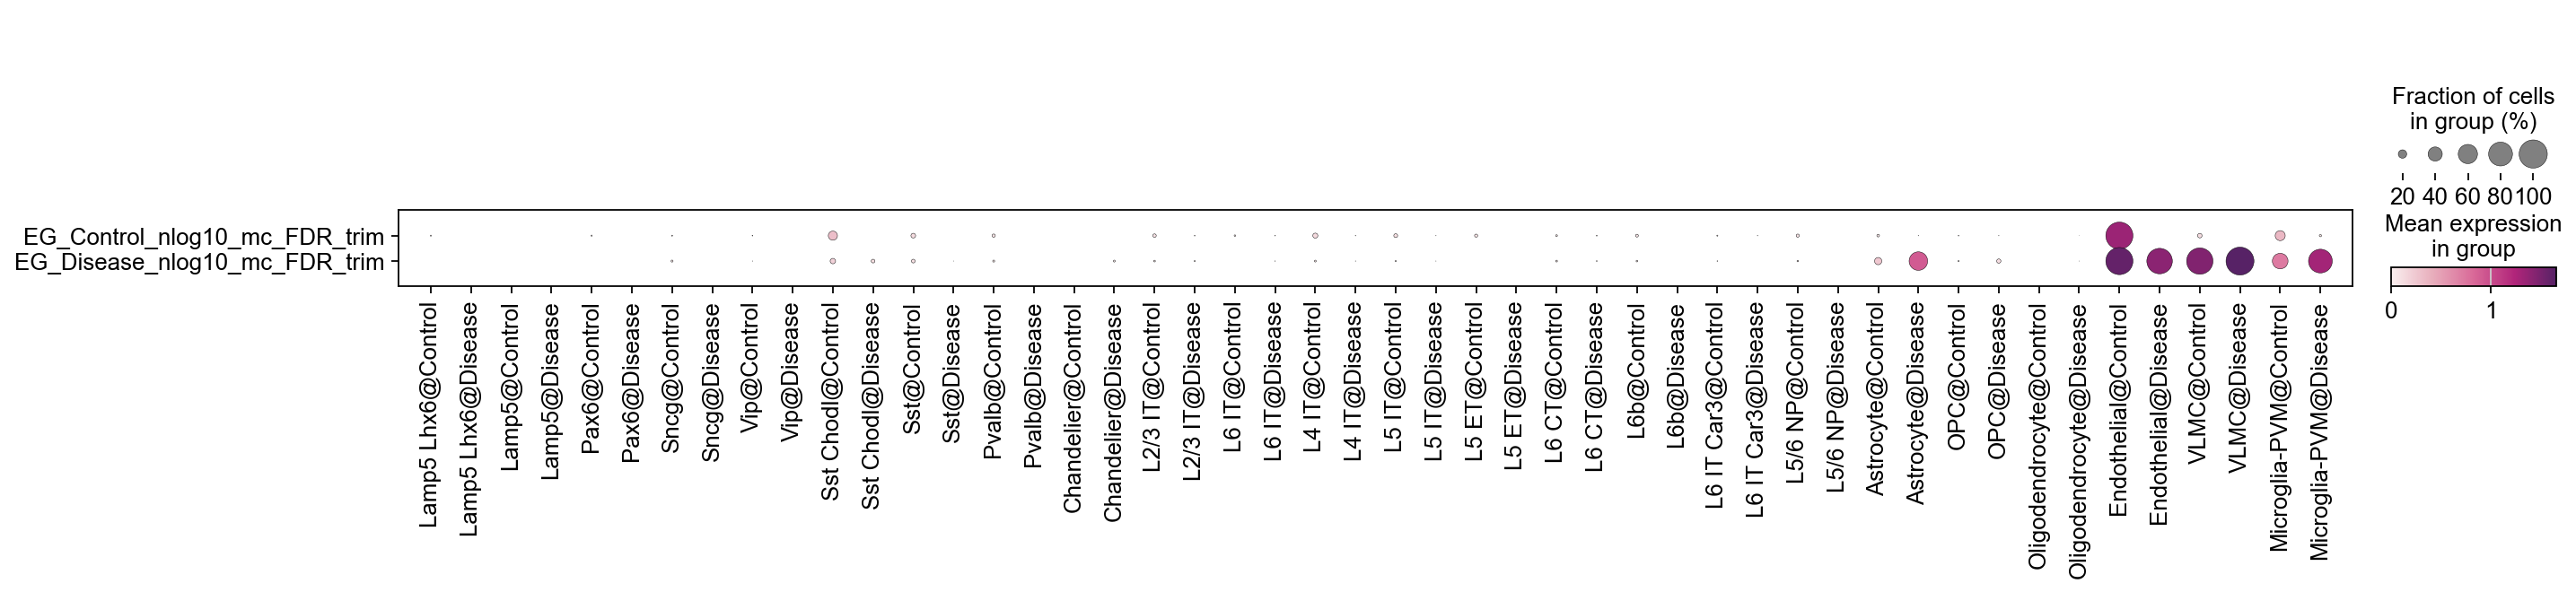

In [29]:
sc.pl.dotplot(
    adata,
    var_names=[key+'_nlog10_mc_FDR_trim' for key in EG_top_geneset_dict.keys()],
    groupby='SubclassXCondition',
    swap_axes=True,
    cmap=piaso.pl.color.c_color4
)

In [30]:
for key in EG_top_geneset_dict.keys():
    tmp=adata.obs[key+'_nlog10_FDR'].copy()
    # tmp[tmp<= (-np.log10(0.05))]=0
    tmp[tmp<= (-np.log10(0.1))]=0
    adata.obs[key+'_nlog10_FDR_trim']=tmp

/n/data1/hms/neurobio/fishell/mindai/.conda/envs/scda5/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:732: RuntimeWarning: invalid value encountered in divide
  frac = (frac - dot_min) / old_range


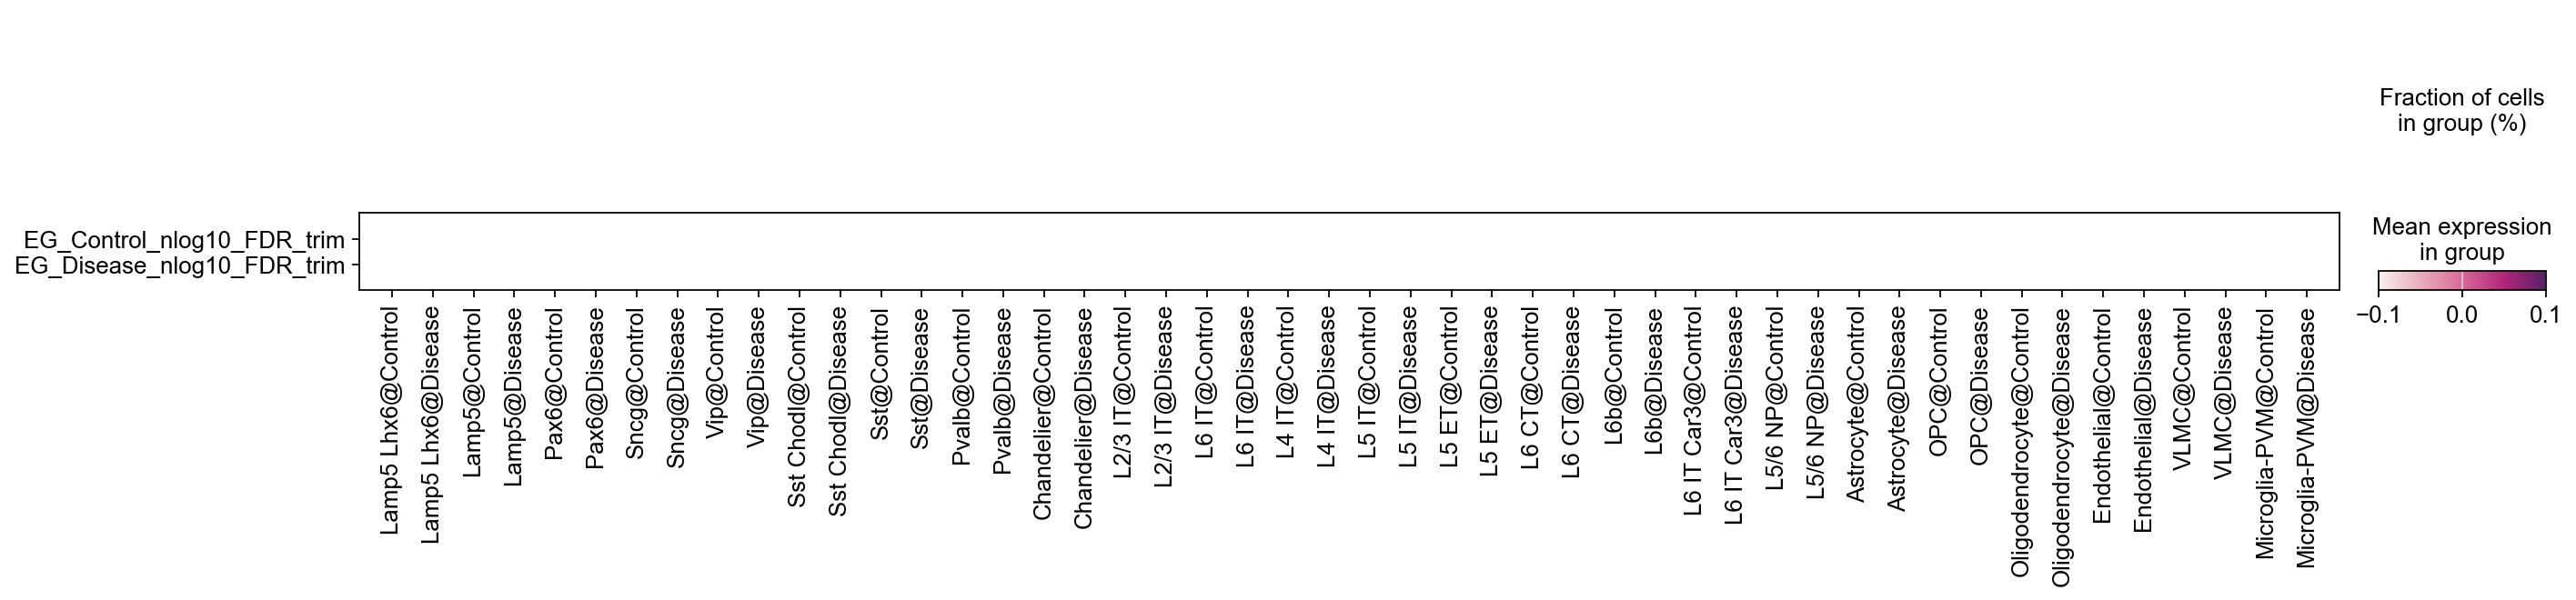

In [31]:
sc.pl.dotplot(
    adata,
    var_names=[key+'_nlog10_FDR_trim' for key in EG_top_geneset_dict.keys()],
    groupby='SubclassXCondition',
    swap_axes=True,
    cmap=piaso.pl.color.c_color4
)

In [32]:
EG_top_geneset_df=eg.pp.convertTopGeneDictToDF(
    EG_top_geneset_dict,
    gene_list_as_string=True,
                      )

In [33]:
EG_top_geneset_df.head(30)

EG_Control_Gene  EG_Control_EG_score EG_Disease_Gene  EG_Disease_EG_score
0            HSPA6             0.521088            CD8B             0.677704
1       AC096637.1             0.475686            CD3G             0.634273
2             PNOC             0.440956            STC1             0.622448
3        LINC01850             0.387791            IL32             0.432223
4         MTRNR2L1             0.382541      AL078604.4             0.420822
5           C2CD4D             0.361422          CYP1B1             0.412565
6            NPTX2             0.358407      AC110992.1             0.408765
7       AL359636.2             0.331661            CCL2             0.380884
8           HS3ST2             0.331475            HAMP             0.341650
9       AC087521.2             0.325633      AC103591.3             0.333371
10      AL009177.1             0.324068            JAML             0.326806
11      AL359237.1             0.319499            FMOD             0.311427
12          HSPA1B             0.315370       LINC01397             0.310604
13      AC021678.2             0.313560            TRAC             0.308594
14           INHBA             0.308551      AC093772.1             0.302154
15      AC115485.1             0.285215      AC004551.1             0.301239
16      AL133259.1             0.281921            RRAD             0.301018
17      AC068205.2             0.280908      AC003991.1             0.290399
18      AC023385.1             0.271051          SLC2A3             0.281729
19          DNAJB1             0.270052       LINC02248             0.278536
20           ABCA4             0.265085      AC002069.2             0.275301
21      AC068205.1             0.256866      AC010609.1             0.273624
22           BCAR4             0.249578           LNCOG             0.272002
23       LINC01339             0.247928           KLRB1             0.270634
24          DNAJA4             0.242970          CHI3L1             0.263076
25           ENPEP             0.242846             OMD             0.259993
26           DUSP5             0.242694      AC090125.1             0.258705
27          CHI3L1             0.239950          HSPA1B             0.257298
28      AC079362.1             0.237304          AKR1C2             0.254771
29         SLCO2A1             0.237011         HSD11B1             0.253105

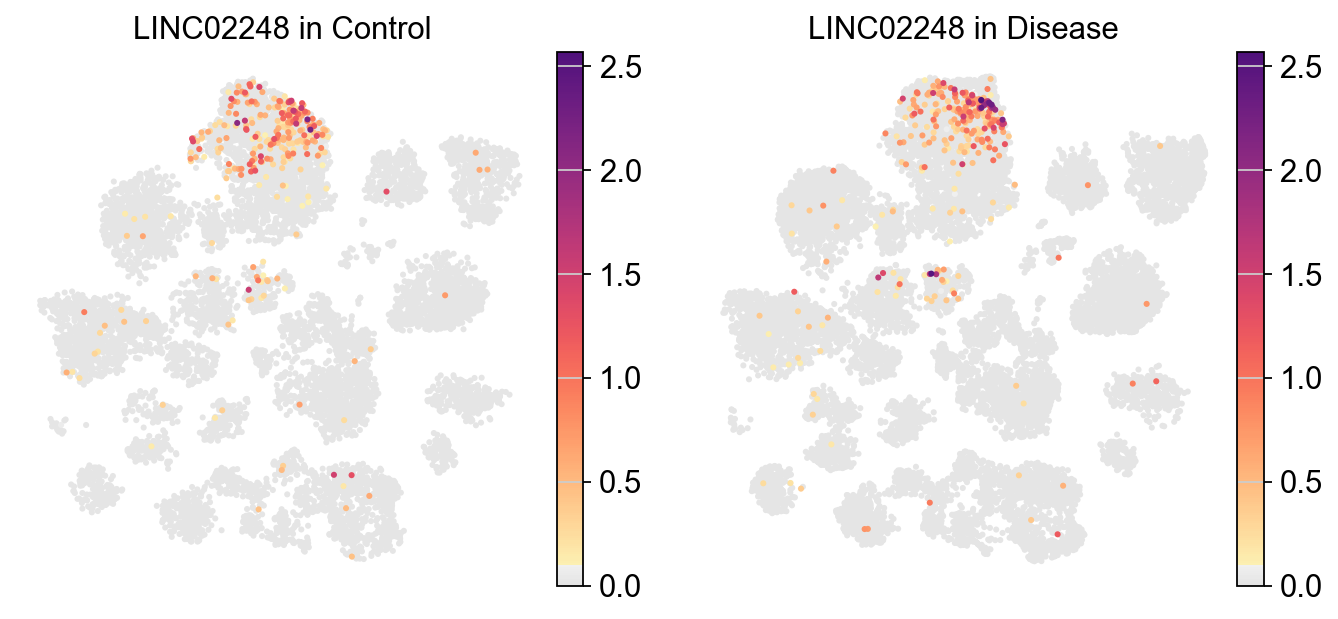

In [34]:
piaso.pl.plot_embeddings_split(
    adata,
    color='LINC02248',
    layer='log1p',
    splitby='Condition',
    color_map=piaso.pl.color.c_color1,
    size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

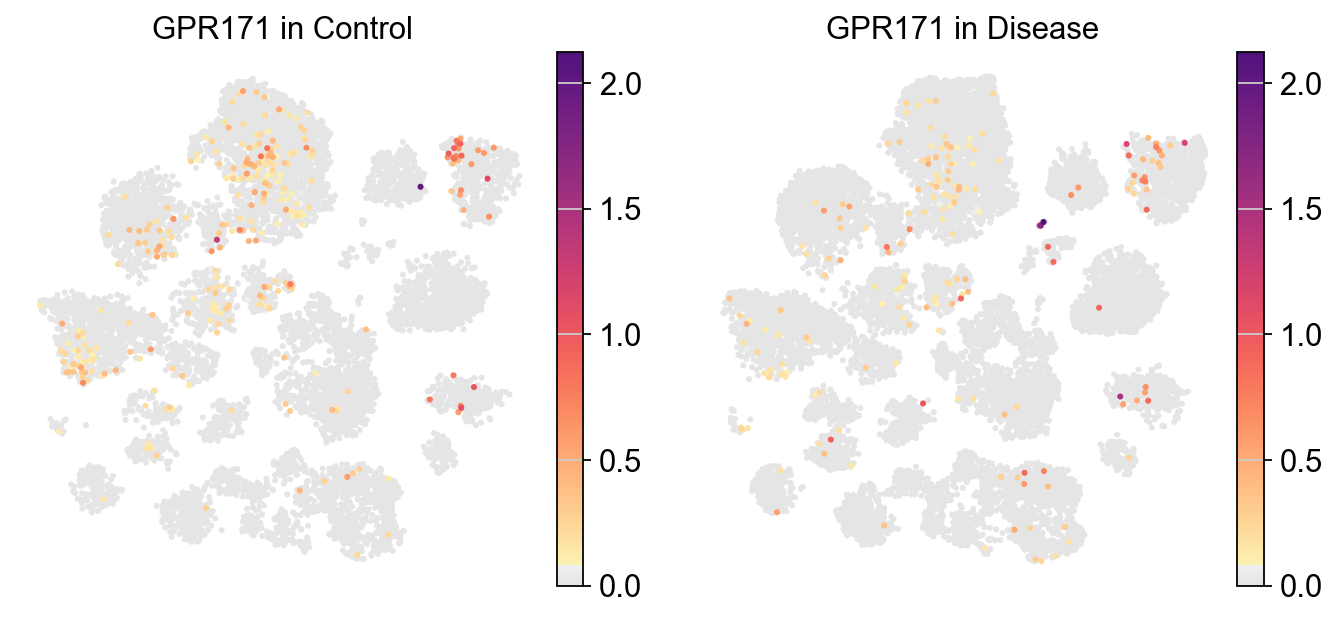

In [35]:
piaso.pl.plot_embeddings_split(
    adata,
    color='GPR171',
    layer='log1p',
    splitby='Condition',
    color_map=piaso.pl.color.c_color1,
    size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

In [36]:
EG_top_geneset_df.head(10)

EG_Control_Gene  EG_Control_EG_score EG_Disease_Gene  EG_Disease_EG_score
0           HSPA6             0.521088            CD8B             0.677704
1      AC096637.1             0.475686            CD3G             0.634273
2            PNOC             0.440956            STC1             0.622448
3       LINC01850             0.387791            IL32             0.432223
4        MTRNR2L1             0.382541      AL078604.4             0.420822
5          C2CD4D             0.361422          CYP1B1             0.412565
6           NPTX2             0.358407      AC110992.1             0.408765
7      AL359636.2             0.331661            CCL2             0.380884
8          HS3ST2             0.331475            HAMP             0.341650
9      AC087521.2             0.325633      AC103591.3             0.333371

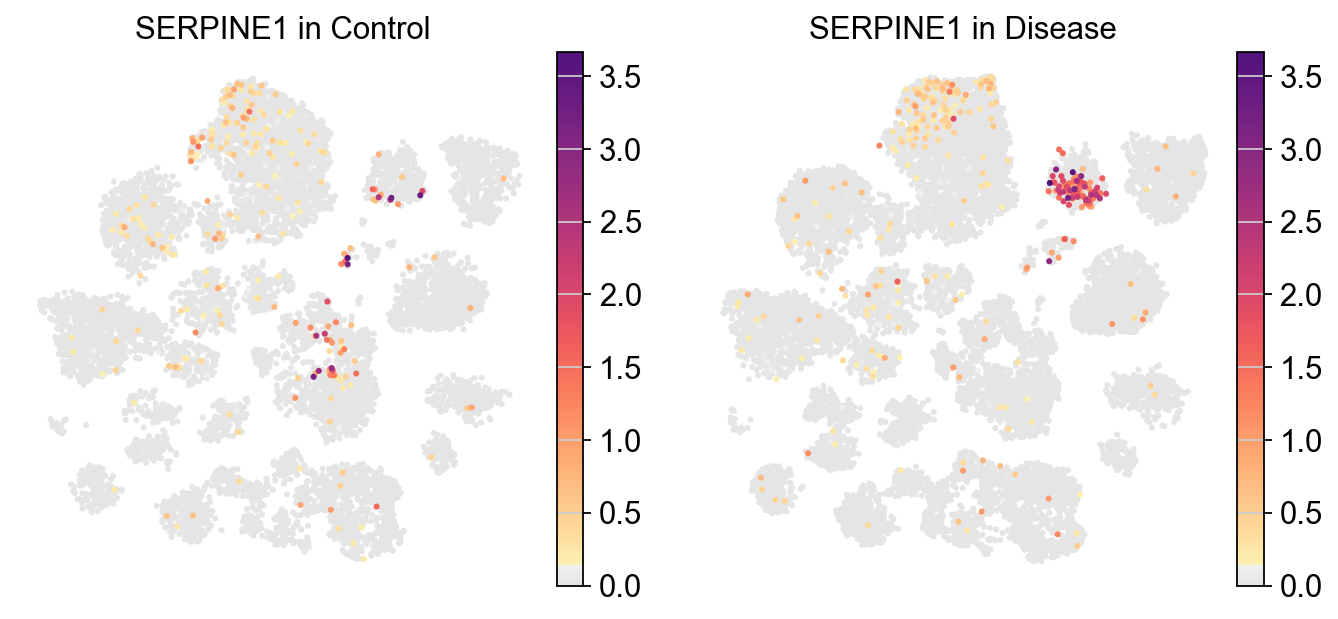

In [37]:
piaso.pl.plot_embeddings_split(
    adata,
    color='SERPINE1',
    layer='log1p',
    splitby='Condition',
    color_map=piaso.pl.color.c_color1,
    size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

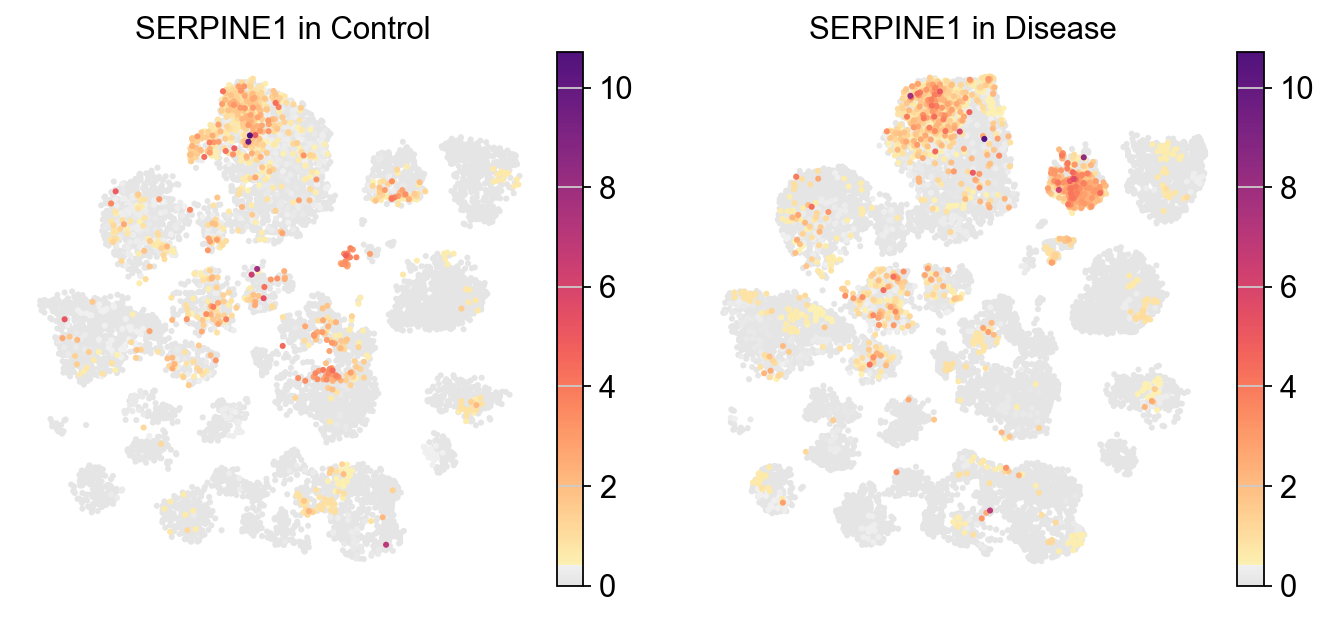

In [38]:
piaso.pl.plot_embeddings_split(
    adata,
    color='SERPINE1',
    layer='localFC',
    splitby='Condition',
    color_map=piaso.pl.color.c_color1,
    size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

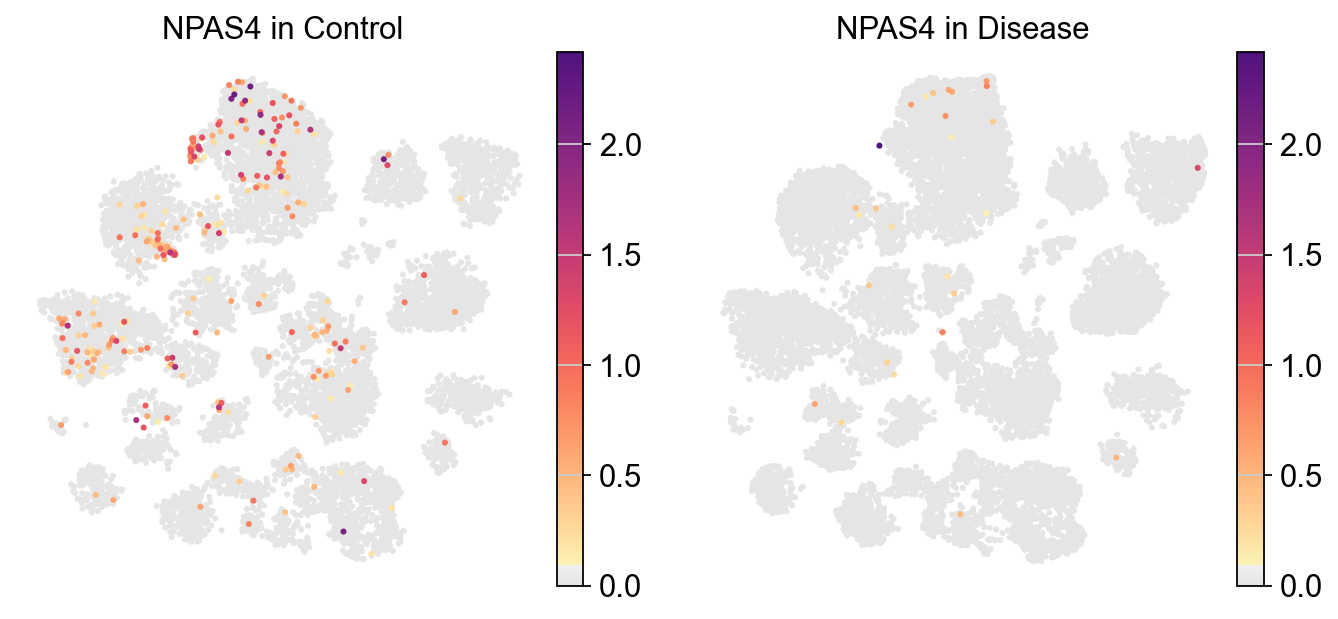

In [39]:
piaso.pl.plot_embeddings_split(
    adata,
    color='NPAS4',
    layer='log1p',
    splitby='Condition',
    color_map=piaso.pl.color.c_color1,
    size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

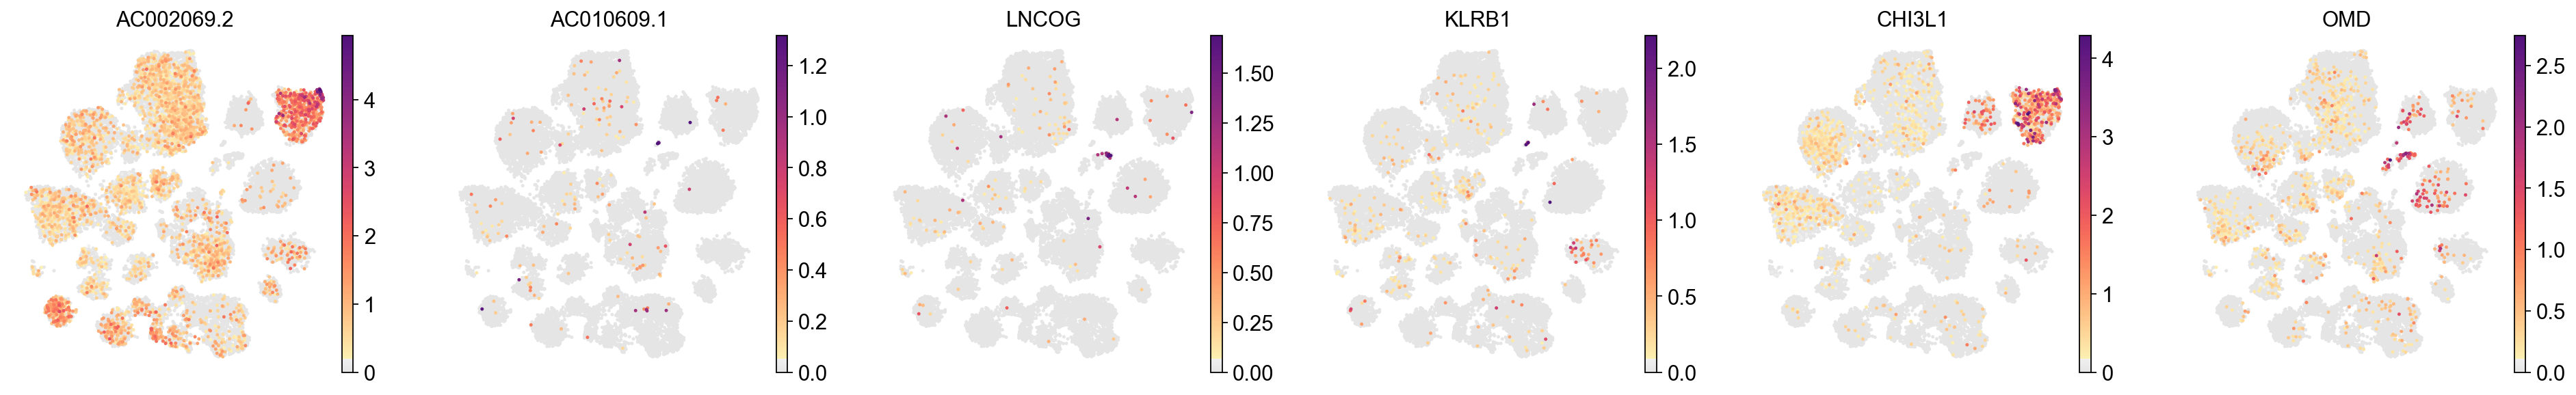

In [40]:
sc.pl.umap(
    adata,
    color=EG_top_geneset_df['EG_Disease_Gene'][20:26],
    color_map=piaso.pl.color.c_color1,
    # vmin=-5,
    # vmax=6,
    s=20,
    ncols=6,
    frameon=False,
)